# Prepare Renewable Potential

This tutorial contains various small guides for tasks you will need or come in handy in the upcoming group assignment.

We're going to need a couple of packages for this tutorial:

In [1]:
import atlite
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Polygon, LineString, Point
from scipy.stats import weibull_min, rayleigh

## Downloading historical weather data from ERA5 with `atlite`

First, let's load some small example country. Let's say, the Netherlands.

In [2]:
regions = gpd.read_file("gadm_410-levels-ADM_1-PHL.gpkg")

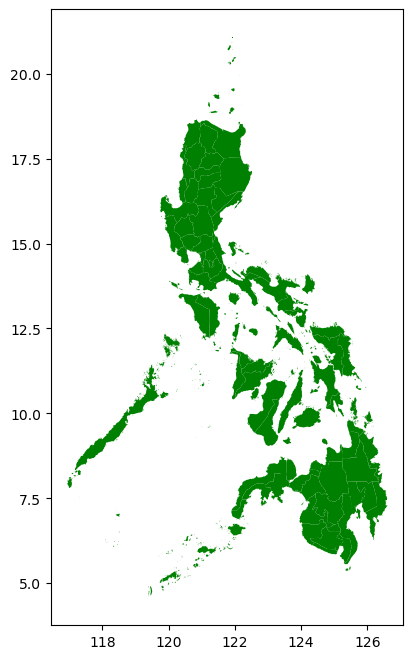

In [3]:
fig, ax = plt.subplots(figsize=(5,8))
regions.plot(ax=ax,color='green')
plt.savefig(f'philippine.png')

In this example we download historical weather data [ERA5 data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) on-demand for a cutout we want to create.

:::{note}
For this example to work, you should have
- installed the Copernicus Climate Data Store `cdsapi` package (`conda list cdsapi` or `pip install cdsapi`) and
- registered and setup your CDS API key as described on [this website](https://cds.climate.copernicus.eu/api-how-to).
:::

A **cutout** is the basis for any of your work and calculations in `atlite`.

The cutout is created in the directory and file specified by the relative path. If a cutout at the given location already exists, then this command will simply load the cutout again. If the cutout does not yet exist, it will specify the new cutout to be created.

For creating the cutout, you need to specify the dataset (e.g. ERA5), a time period and the spatial extent (in latitude and longitude).

In [4]:
minx, miny, maxx, maxy = regions.total_bounds
buffer = 0.25

cutout = atlite.Cutout(
   path="PHL_atlite.nc",
   module="era5",
   x=slice(minx-buffer, maxx+buffer),
   y=slice(miny-buffer, maxy+buffer),
   time="2013",
)

#cutout.prepare()

C:\Users\M. Indrayana\.conda\envs\base_m\envs\pypsa-eur\lib\site-packages\atlite\cutout.py:185: UserWarning: Arguments module, x, y, time are ignored, since cutout is already built.
  warn(


Calling the function `cutout.prepare()` initiates the download and processing of the weather data.
Because the download needs to be provided by the CDS servers, this might take a while depending on the amount of data requested.

:::{note}
You can check the status of your request [here](https://cds.climate.copernicus.eu/cdsapp#!/yourrequests).
:::

In [5]:
#url = "https://tubcloud.tu-berlin.de/s/5XE2FWCfkRc4kAm/download/PHL_atlite.nc"

#urlretrieve(url, "PHL_atlite.nc")

cutout = atlite.Cutout("PHL_atlite.nc") # if cutout not yet in computer

<GeoAxesSubplot:xlabel='x', ylabel='y'>

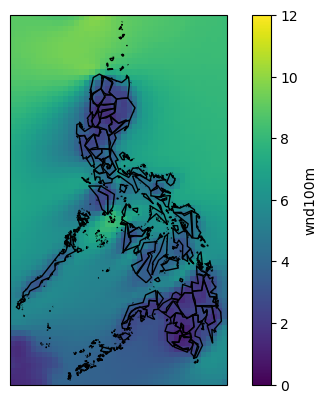

In [6]:
ax = plt.axes(projection=ccrs.PlateCarree())

cutout.data.wnd100m.mean(dim='time').plot(ax=ax, vmin=0, vmax=12)
regions.simplify(0.1).to_crs(4236).plot(ax=ax, edgecolor='k', color='none')

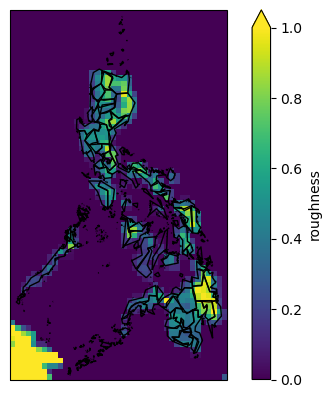

In [7]:
ax = plt.axes(projection=ccrs.PlateCarree())

cutout.data.roughness.mean(dim='time').plot(ax=ax, vmin=0, vmax=1)
regions.simplify(0.1).to_crs(4236).plot(ax=ax, edgecolor='k', color='none')
plt.savefig(f'roughness.png')

In [11]:
def extrapolate_wind_speed(hub_height,year):
    
    # v = v ref ln(z/z 0 )/ln(z ref /z 0 )
    cutout = atlite.Cutout(f"PHL_atlite_{year}.nc")
    wind_100 = cutout.data.wnd100m
    roughness = cutout.data.roughness
    wind_array = wind_100 * np.log(hub_height/roughness)/np.log(100/roughness)
    
    return wind_array

def region_wind(wind_array,region):
    cell_data=[]
    for x in np.arange(116.75,126.57,0.25):
        x = round(x,2)
        for y in np.arange(4.5,21.25,0.25):
            buffer = Point(x, y).buffer(0.25, cap_style = 3)
            if region.simplify(0.1).overlaps(buffer):
                x_cell = int((x - 116.8)*4)
                y_cell = int((y - 4.5)*4)
                cell_data= cell_data + [[y_cell,x_cell]]

    return sum(wind_array[:,y,x].to_pandas() for y,x in cell_data)/len(cell_data)
        
def wind_hist(df,name,wind_height):
    n, bins = np.histogram(df, bins=np.arange(0,35,1))
    wind=bins[:-1]#+0.5
    freq=n/8760
    
    plt.bar(x=wind,height=freq, width=1)
    x = np.arange(0,bins.max()*100.)/10.
    
    c, loc, scale = weibull_min.fit(df)
    plt.plot(x, weibull_min.pdf(x, c, loc, scale),'r-', lw=3, alpha=0.6, 
             label=f'weibull_min pdf \nk={round(c,2)} \nlambda={round(loc,2)}')
    
    loc, scale = rayleigh.fit(df)
    plt.plot(x, rayleigh.pdf(x, loc, scale),'g-', lw=3, alpha=0.6, 
             label=f'rayleigh pdf \nsigma={round(loc,2)}')
    
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Windgeschwindigkeit [m/s]')
    plt.ylabel('Häufigkeit')
    plt.xlim([0,34])
    plt.title(f'Wind Histogram of {name} in {wind_height}m')
    plt.legend()
    #plt.savefig(f'wind_histogram\wind_hist_100_{name}.png')
    
def compile_hist(island,hub_height,years):
    for height in hub_height:
        df = pd.DataFrame()
        for year in years:
            wind_array = extrapolate_wind_speed(height,year)
            for i in regions.index:
                if regions.NAME_1[i] in island:
                    print('compiling ' + regions.NAME_1[i]  + 'for year ' + year)
                    wind_series = region_wind(wind_array,regions.geometry[i])
                    n, bins = np.histogram(wind_series, bins=np.arange(0,35,1))
                    df_new = pd.DataFrame(n.reshape(-1, len(n)), index = [regions.NAME_1[i]])
                    
                    df_new["year"] = year
                    cols = df_new.columns.tolist()
                    cols = cols[-1:] + cols[:-1]
                    df_new = df[cols]
                    
                    df = pd.concat([df,df_new])

        df.to_csv(f'wind_histogram/wind_hist_{str(height)}_n.csv')
    return df


In [12]:
island = {"Batanes","Bohol","Catanduanes","Marinduque","Tawi-Tawi"}
years = {"1980","1990","2000","2010","2020",}
hub_height = {12,24,28.5,29,30}
hub_height = {12}
df_hist = compile_hist(island,hub_height,years)

compiling Batanesfor year 2000


KeyError: "None of [Index(['year',      0,      1,      2,      3,      4,      5,      6,      7,\n            8,      9,     10,     11,     12,     13,     14,     15,     16,\n           17,     18,     19,     20,     21,     22,     23,     24,     25,\n           26,     27,     28,     29,     30,     31,     32,     33],\n      dtype='object')] are in the [columns]"

In [28]:
regions.NAME_1[10]
regions.NAME_1[14]
regions.NAME_1[22]
regions.NAME_1[44]
regions.NAME_1[76]

'Batanes'

C:\Users\kunde\anaconda3\envs\esm\lib\site-packages\scipy\stats\_continuous_distns.py:7762: RuntimeWarning: divide by zero encountered in divide
  s3 = (1/xm).sum()


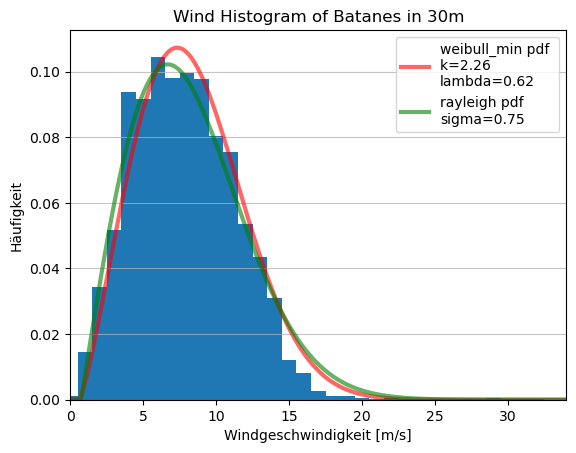

In [401]:
region=10
wind_height=30

wind_array = extrapolate_wind_speed(wind_height)
wind_series = region_wind(wind_array,regions.geometry[region])
wind_hist(wind_series,regions.NAME_1[region],wind_height)

<AxesSubplot: xlabel='time'>

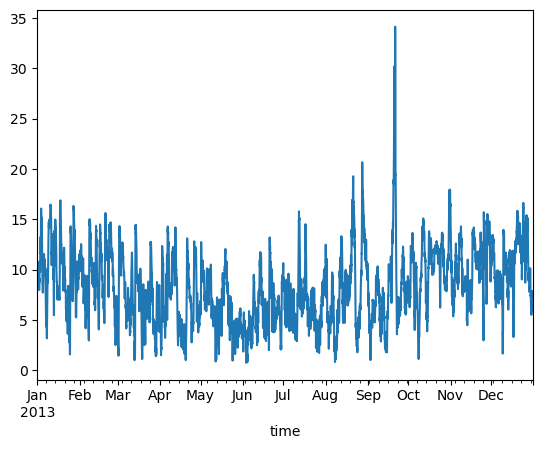

In [33]:
wind_series.plot()